# Model and Task Definitions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import BeliefPropagation
from joblib import Parallel, delayed
    
# Define function to generate stimuli
def gen_stims(n, stability=.5, csc=[.5, .5]):

  # Define probabilities
  p_c__c = np.array([
      [stability, 1-stability],
      [1-stability, stability]
  ])
  p_e__c = np.array([
      [csc[0], csc[1]],
      [1-csc[0], 1-csc[1]],
  ])

  stims = np.empty((0, 2))
  previous_c = None
  for i in range(n-1):
    stim = np.array([None, None])
    if previous_c is None:
      stim[0] = np.random.choice([0, 1], p=[.5, .5])
    else:
      stim[0] = np.random.choice([0, 1], p=p_c__c[:, previous_c])
    stim[1] = np.random.choice([0, 1], p=p_e__c[:, stim[0]])

    stims = np.vstack((stims, stim))
    previous_c = stim[0]

  stims[:, 0] = np.where(stims[:, 0] == 0, 'lower', 'upper')
  stims[:, 1] = np.where(stims[:, 1] == 0, 'con', 'incon')

  return stims

/opt/homebrew/Caskroom/miniconda/base/envs/ipython/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
class Dirichlet():
    def __init__(self, init_values):
        self.values = np.array(init_values, dtype='float64')

    def infer(self, observations):
        self.values += observations  # this is the very basic update function to get the posterior

    def get_mean_cpd(self):
        return self.values / self.values.sum(axis=0)
    
class SimpleModel():

    def __init__(self, con_exp):

        self.p_con = np.array([con_exp, 1-con_exp])

        self.model = BayesianNetwork([
            ('l', 'e'),
        ])

        # Hyperpriors
        self.theta = Dirichlet(init_values=[  # p(e | l, theta)
            [.5, .5],
            [.5, .5]
        ])

        # CPDs
        cpd_l = TabularCPD('l', 2, [[.5], [.5]], state_names={'l': ['lower', 'upper']})
        cpd_e = TabularCPD('e', 2, evidence=['l'], evidence_card=[2],
                   values=self.theta.get_mean_cpd(), 
                   state_names={'e': ['con', 'incon'], 'l': ['lower', 'upper']})
        self.model.add_cpds(cpd_l, cpd_e)

        # Mappings
        self.l_map = {'lower': 0, 'upper': 1}
        self.e_map = {'con': 0, 'incon': 1}
    
    def predict_entropy(self, l):
        inference = BeliefPropagation(self.model)
        self.e_prediction = inference.query(['e'], evidence={'l': l}).values
    
    def learn(self, l, e):
        # Theta
        obs_theta = np.zeros((2, 2))
        obs_theta[self.e_map[e], self.l_map[l]] = 1
        self.theta.infer(obs_theta)

        # Update cpds
        cpd_e = TabularCPD('e', 2, evidence=['l'], evidence_card=[2],
                   values=self.theta.get_mean_cpd(), 
                   state_names={'e': ['con', 'incon'], 'l': ['lower', 'upper']})
        self.model.add_cpds(cpd_e)

class LatentModel():

    def __init__(self, con_exp):

        self.p_con = np.array([con_exp, 1-con_exp])

        self.model = BayesianNetwork([
            ('l', 'c'),
            ('c', 'e'),
        ])

        # Hyperpriors
        self.theta = Dirichlet(init_values=[  # p(c | l, theta)
            [.5, .5],
            [.5, .5]
        ])
        self.phi = Dirichlet(init_values=[  # p(e | c, phi)
            [.5, .5],
            [.5, .5]
        ])

        # CPDs
        cpd_l = TabularCPD('l', 2, [[.5], [.5]], state_names={'l': ['lower', 'upper']})
        cpd_c = TabularCPD('c', 2, evidence=['l'], evidence_card=[2],
                   values=self.theta.get_mean_cpd(), 
                   state_names={'c': ['0', '1'], 'c_prev': ['0', '1'], 'l': ['lower', 'upper']})
        cpd_e = TabularCPD('e', 2, evidence=['c'], evidence_card=[2],
                   values=self.phi.get_mean_cpd(), 
                   state_names={'e': ['con', 'incon'], 'c': ['0', '1']})
        self.model.add_cpds(cpd_l, cpd_c, cpd_e)

        # Mappings
        self.l_map = {'lower': 0, 'upper': 1}
        self.e_map = {'con': 0, 'incon': 1}
    
    def predict_entropy(self, l):
        inference = BeliefPropagation(self.model)
        self.c_proactive = inference.query(['c']).values
        self.c_reactive = inference.query(['c'], evidence={'l': l}).values
        self.e_prediction = inference.query(['e'], evidence={'l': l}).values
    
    def observe_entropy(self, l, e):
        inference = BeliefPropagation(self.model)
        self.c_posterior = inference.query(['c'], evidence={'l': l, 'e': e}).values
    
    def learn(self, l, e):
        # Theta
        obs_theta = np.zeros((2, 2))
        obs_theta[:, self.l_map[l]] = self.c_posterior
        self.theta.infer(obs_theta)

        # Phi
        obs_phi = np.zeros((2, 2))
        obs_phi[self.e_map[e], :] = self.c_posterior
        self.phi.infer(obs_phi)

        # Update cpds
        cpd_c = TabularCPD('c', 2, evidence=['l'], evidence_card=[2],
                   values=self.theta.get_mean_cpd(), 
                   state_names={'c': ['0', '1'], 'c_prev': ['0', '1'], 'l': ['lower', 'upper']})
        cpd_e = TabularCPD('e', 2, evidence=['c'], evidence_card=[2],
                   values=self.phi.get_mean_cpd(), 
                   state_names={'e': ['con', 'incon'], 'c': ['0', '1']})
        self.model.add_cpds(cpd_c, cpd_e)       

class IntentionModel():
    def p_c__i_l(self):
        unnorm = self.p_c__i[:, :, None] * self.theta.get_mean_cpd()[:, None, :]
        return unnorm / unnorm.sum(axis=0, keepdims=True)

    def __init__(self, free, int_strength, con_exp):

        self.free = free
        self.p_con = np.array([con_exp, 1-con_exp])

        self.model = BayesianNetwork([
            ('i', 'c'),
            ('l', 'c'),
            ('c', 'e'),
        ])

        # Hyperpriors
        self.theta = Dirichlet(init_values=[  # p(c | l, theta)
            [.5, .5],
            [.5, .5]
        ])
        self.phi = Dirichlet(init_values=[  # p(e | c, phi)
            [.5, .5],
            [.5, .5]
        ])

        self.p_c__i = np.array([  # how much the intention actives the hidden context
            [int_strength, 1-int_strength],
            [1-int_strength, int_strength]
        ])

        # CPDs
        cpd_c_prev = TabularCPD('i', 2, [[.5], [.5]], state_names={'i': ['lower', 'upper']})
        cpd_l = TabularCPD('l', 2, [[.5], [.5]], state_names={'l': ['lower', 'upper']})
        cpd_c = TabularCPD('c', 2, evidence=['i', 'l'], evidence_card=[2, 2],
                   values=self.p_c__i_l().reshape(2, -1), 
                   state_names={'c': ['0', '1'], 'i': ['lower', 'upper'], 'l': ['lower', 'upper']})
        cpd_e = TabularCPD('e', 2, evidence=['c'], evidence_card=[2],
                   values=self.phi.get_mean_cpd(), 
                   state_names={'e': ['con', 'incon'], 'c': ['0', '1']})
        self.model.add_cpds(cpd_c_prev, cpd_l, cpd_c, cpd_e)

        # Mappings
        self.l_map = {'lower': 0, 'upper': 1}
        self.e_map = {'con': 0, 'incon': 1}
    
    def predict_entropy(self, l):
        inference = BeliefPropagation(self.model)
        if self.free:
            self.c_proactive = inference.query(['c'], evidence={'i': l}).values
            self.c_reactive = inference.query(['c'], evidence={'i': l, 'l': l}).values
            self.e_prediction = inference.query(['e'], evidence={'i': l, 'l': l}).values
        else:
            self.c_proactive = inference.query(['c']).values
            self.c_reactive = inference.query(['c'], evidence={'l': l}).values
            self.e_prediction = inference.query(['e'], evidence={'l': l}).values
    
    def observe_entropy(self, l, e):
        inference = BeliefPropagation(self.model)
        if self.free:
            self.c_posterior = inference.query(['c'], evidence={'i': l, 'l': l, 'e': e}).values
        else:
            self.c_posterior = inference.query(['c'], evidence={'l': l, 'e': e}).values
    
    def learn(self, l, e):
        # Theta
        obs_theta = np.zeros((2, 2))
        obs_theta[:, self.l_map[l]] = self.c_posterior
        self.theta.infer(obs_theta)

        # Phi
        obs_phi = np.zeros((2, 2))
        obs_phi[self.e_map[e], :] = self.c_posterior
        self.phi.infer(obs_phi)

        # Update cpds
        cpd_c = TabularCPD('c', 2, evidence=['i', 'l'], evidence_card=[2, 2],
                   values=self.p_c__i_l().reshape(2, -1), 
                   state_names={'c': ['0', '1'], 'i': ['lower', 'upper'], 'l': ['lower', 'upper']})
        cpd_e = TabularCPD('e', 2, evidence=['c'], evidence_card=[2],
                   values=self.phi.get_mean_cpd(), 
                   state_names={'e': ['con', 'incon'], 'c': ['0', '1']})
        self.model.add_cpds(cpd_c, cpd_e)

class SchedulingModel():
    def p_c__c_prev_l(self):
        unnorm = self.p_c__c_prev[:, :, None] * self.theta.get_mean_cpd()[:, None, :]
        return unnorm / unnorm.sum(axis=0, keepdims=True)

    def __init__(self, stability, con_exp, learn_prior=1):

        self.p_con = np.array([con_exp, 1-con_exp])

        self.model = BayesianNetwork([
            ('c_prev', 'c'),
            ('l', 'c'),
            ('c', 'e'),
        ])

        # Hyperpriors
        self.theta = Dirichlet(init_values=[  # p(c | l, theta)
            [learn_prior, learn_prior],
            [learn_prior, learn_prior]
        ])
        self.phi = Dirichlet(init_values=[  # p(e | c, phi)
            [learn_prior, learn_prior],
            [learn_prior, learn_prior]
        ])

        # Fix temporal stability assumption
        self.p_c_prev = np.array([.99, .01])  # initialize one latent state
        self.p_c__c_prev = np.array([
            [stability, 1-stability],
            [1-stability, stability]
        ])

        # CPDs
        cpd_c_prev = TabularCPD('c_prev', 2, self.p_c_prev.reshape(-1, 1), state_names={'c_prev': ['0', '1']})
        cpd_l = TabularCPD('l', 2, [[.5], [.5]], state_names={'l': ['lower', 'upper']})
        cpd_c = TabularCPD('c', 2, evidence=['c_prev', 'l'], evidence_card=[2, 2],
                   values=self.p_c__c_prev_l().reshape(2, -1), 
                   state_names={'c': ['0', '1'], 'c_prev': ['0', '1'], 'l': ['lower', 'upper']})
        cpd_e = TabularCPD('e', 2, evidence=['c'], evidence_card=[2],
                   values=self.phi.get_mean_cpd(), 
                   state_names={'e': ['con', 'incon'], 'c': ['0', '1']})
        self.model.add_cpds(cpd_c_prev, cpd_l, cpd_c, cpd_e)

        # Mappings
        self.l_map = {'lower': 0, 'upper': 1}
        self.e_map = {'con': 0, 'incon': 1}
    
    def predict_entropy(self, l):
        inference = BeliefPropagation(self.model)
        self.c_proactive = inference.query(['c']).values
        self.c_reactive = inference.query(['c'], evidence={'l': l}).values
        self.e_prediction = inference.query(['e'], evidence={'l': l}).values
    
    def observe_entropy(self, l, e):
        inference = BeliefPropagation(self.model)
        self.c_posterior = inference.query(['c'], evidence={'l': l, 'e': e}).values
    
    def learn(self, l, e):
        # Theta
        obs_theta = np.zeros((2, 2))
        obs_theta[:, self.l_map[l]] = self.c_posterior
        self.theta.infer(obs_theta)

        # Phi
        obs_phi = np.zeros((2, 2))
        obs_phi[self.e_map[e], :] = self.c_posterior
        self.phi.infer(obs_phi)

        # Update cpds
        cpd_c = TabularCPD('c', 2, evidence=['c_prev', 'l'], evidence_card=[2, 2],
                   values=self.p_c__c_prev_l().reshape(2, -1), 
                   state_names={'c': ['0', '1'], 'c_prev': ['0', '1'], 'l': ['lower', 'upper']})
        cpd_e = TabularCPD('e', 2, evidence=['c'], evidence_card=[2],
                   values=self.phi.get_mean_cpd(), 
                   state_names={'e': ['con', 'incon'], 'c': ['0', '1']})
        self.model.add_cpds(cpd_c, cpd_e)

    def update_c(self):
        self.p_c_prev = self.c_posterior
        cpd_c_prev = TabularCPD('c_prev', 2, self.p_c_prev.reshape(-1, 1), state_names={'c_prev': ['0', '1']})
        self.model.add_cpds(cpd_c_prev)
    
    def change_stability(self, stability):
        self.p_c__c_prev = np.array([  # stability assumption
            [stability, 1-stability],
            [1-stability, stability]
        ])
        cpd_c = TabularCPD('c', 2, evidence=['l'], evidence_card=[2],
                   values=self.theta.get_mean_cpd().reshape(2, -1), 
                   state_names={'c': ['0', '1'], 'l': ['lower', 'upper']})
        self.model.add_cpds(cpd_c)    

# Simulations

In [32]:
def sim_cspc_simple(stability_data, csc, con_exp, n=1200, stims=None):
    stims = gen_stims(n, stability=stability_data, csc=csc)
    model = SimpleModel(con_exp=con_exp)
    data = []
    for i, stim in enumerate(stims):
        model.predict_entropy(stim[0])
        model.learn(stim[0], stim[1])

        e_adjusted = model.e_prediction * model.p_con
        e_adjusted /= e_adjusted.sum()

        data.append({
            'location': stim[0],
            'congruency': stim[1],
            'e_prediction': model.e_prediction[0],
            'p_e__l0': model.theta.get_mean_cpd()[0, 0],
            'p_e__l1': model.theta.get_mean_cpd()[0, 1],
            'surprise': - np.log(e_adjusted[model.e_map[stim[1]]]) 
        })

    return pd.DataFrame(data)

def sim_cspc_latent(stability_data, csc, con_exp, init_stability=.8, n=1200, stims=None):
    if stims is None:
        stims = gen_stims(n, stability=stability_data, csc=csc)
    s_model = SchedulingModel(stability=init_stability, con_exp=con_exp)
    data = []
    for i, stim in enumerate(stims):
        s_model.predict_entropy(stim[0])
        s_model.observe_entropy(stim[0], stim[1])
        s_model.learn(stim[0], stim[1])

        e_adjusted = s_model.e_prediction * s_model.p_con
        e_adjusted /= e_adjusted.sum()

        data.append({
            'trial': i,
            'location': stim[0],
            'congruency': stim[1],
            'c_proactive': s_model.c_proactive[0],
            'c_reactive': s_model.c_reactive[0],
            'c_posterior': s_model.c_posterior[0],
            'e_prediction': s_model.e_prediction[0],
            'p_c__l0': s_model.theta.get_mean_cpd()[0, 0],
            'p_c__l1': s_model.theta.get_mean_cpd()[0, 1],
            'p_e__c0': s_model.phi.get_mean_cpd()[0, 0],
            'p_e__c1': s_model.phi.get_mean_cpd()[0, 1],
            'surprise': - np.log(e_adjusted[s_model.e_map[stim[1]]]) 
        })

        if i == 0:
            s_model.change_stability(.5)

    return pd.DataFrame(data)

def sim_cspc_intention(stability_data, csc, free_choice, int_strength, con_exp, n=1200, stims=None):
    if stims is None:
        stims = gen_stims(n, stability=stability_data, csc=csc)
    i_model = IntentionModel(free=free_choice, int_strength=int_strength, con_exp=con_exp)
    data = []
    for i, stim in enumerate(stims):
        i_model.predict_entropy(stim[0])
        i_model.observe_entropy(stim[0], stim[1])
        i_model.learn(stim[0], stim[1])

        e_adjusted = i_model.e_prediction * i_model.p_con
        e_adjusted /= e_adjusted.sum()

        data.append({
            'trial': i,
            'location': stim[0],
            'congruency': stim[1],
            'c_proactive': i_model.c_proactive[0],
            'c_reactive': i_model.c_reactive[0],
            'c_posterior': i_model.c_posterior[0],
            'e_prediction': i_model.e_prediction[0],
            'p_c__l0': i_model.theta.get_mean_cpd()[0, 0],
            'p_c__l1': i_model.theta.get_mean_cpd()[0, 1],
            'p_e__c0': i_model.phi.get_mean_cpd()[0, 0],
            'p_e__c1': i_model.phi.get_mean_cpd()[0, 1],
            'surprise': - np.log(e_adjusted[i_model.e_map[stim[1]]]) 
        })

    return pd.DataFrame(data)

def sim_cspc_schedule(stability_data, csc, stability_assumption, con_exp, n=1200, stims=None):
    if stims is None:
        stims = gen_stims(n, stability=stability_data, csc=csc)
    s_model = SchedulingModel(stability=stability_assumption, con_exp=con_exp, learn_prior=.2)
    data = []
    for i, stim in enumerate(stims):
        s_model.predict_entropy(stim[0])
        s_model.observe_entropy(stim[0], stim[1])
        s_model.learn(stim[0], stim[1])
        s_model.update_c()

        e_adjusted = s_model.e_prediction * s_model.p_con
        e_adjusted /= e_adjusted.sum()

        data.append({
            'trial': i,
            'location': stim[0],
            'congruency': stim[1],
            'c_proactive': s_model.c_proactive[0],
            'c_reactive': s_model.c_reactive[0],
            'c_posterior': s_model.c_posterior[0],
            'e_prediction': s_model.e_prediction[0],
            'p_c__l0': s_model.theta.get_mean_cpd()[0, 0],
            'p_c__l1': s_model.theta.get_mean_cpd()[0, 1],
            'p_e__c0': s_model.phi.get_mean_cpd()[0, 0],
            'p_e__c1': s_model.phi.get_mean_cpd()[0, 1],
            'surprise': - np.log(e_adjusted[s_model.e_map[stim[1]]]) 
        })

    return pd.DataFrame(data)

In [33]:
def run_id(i, pc, con_exp, n):
    
    # Forced condition
    stims = gen_stims(n, stability=.5, csc=pc)

    #data_latent_i = sim_cspc_latent(stability_data, pc, con_exp=con_exp, init_stability=.8, n=n, stims=stims)
    #data_latent_i['model'] = 'latent'
    #data_latent_i['id'] = i
    #data_latent_i['condition'] = 'forced'
    data_latent_i = pd.DataFrame()
#
    #data_intention_i = sim_cspc_intention(stability_data, pc, free_choice=False, int_strength=.6, con_exp=con_exp, n=n, stims=stims)
    #data_intention_i['model'] = 'intention'
    #data_intention_i['id'] = i
    #data_intention_i['condition'] = 'forced'
    data_intention_i = pd.DataFrame()

    data_schedule_forced_i = sim_cspc_schedule(.5, pc, stability_assumption=.8, con_exp=con_exp, n=n, stims=stims)
    data_schedule_forced_i['model'] = 'schedule'
    data_schedule_forced_i['id'] = i
    data_schedule_forced_i['condition'] = 'forced'

    # Free choice condition
    stims = gen_stims(n, stability=.8, csc=pc)

    #data_latent_i = sim_cspc_latent(stability_data, pc, con_exp=con_exp, init_stability=.8, n=n, stims=stims)
    #data_latent_i['model'] = 'latent'
    #data_latent_i['id'] = i
    #data_latent_i['condition'] = 'free'
    data_latent_i = pd.DataFrame()
#
    #data_intention_i = sim_cspc_intention(stability_data, pc, free_choice=True, int_strength=.6, con_exp=con_exp, n=n, stims=stims)
    #data_intention_i['model'] = 'intention'
    #data_intention_i['id'] = i
    #data_intention_i['condition'] = 'free'
    data_intention_i = pd.DataFrame()

    data_schedule_free_i = sim_cspc_schedule(.8, pc, stability_assumption=.8, con_exp=con_exp, n=n, stims=stims)
    data_schedule_free_i['model'] = 'schedule'
    data_schedule_free_i['id'] = i
    data_schedule_free_i['condition'] = 'free'

    # Yoked condition (using same stims)
    #data_latent_i = sim_cspc_latent(stability_data, pc, con_exp=con_exp, init_stability=.8, n=n, stims=stims)
    #data_latent_i['model'] = 'latent'
    #data_latent_i['id'] = i
    #data_latent_i['condition'] = 'free'
    data_latent_i = pd.DataFrame()
#
    #data_intention_i = sim_cspc_intention(stability_data, pc, free_choice=False, int_strength=.6, con_exp=con_exp, n=n, stims=stims)
    #data_intention_i['model'] = 'intention'
    #data_intention_i['id'] = i
    #data_intention_i['condition'] = 'free'
    data_intention_i = pd.DataFrame()

    data_schedule_yoked_i = sim_cspc_schedule(.8, pc, stability_assumption=.8, con_exp=con_exp, n=n, stims=stims)
    data_schedule_yoked_i['model'] = 'schedule'
    data_schedule_yoked_i['id'] = i
    data_schedule_yoked_i['condition'] = 'yoked'

    data_schedule_i = pd.concat((data_schedule_forced_i, data_schedule_free_i, data_schedule_yoked_i))

    return [data_latent_i, data_intention_i, data_schedule_i]

data = pd.DataFrame()
pc = [.2, .8]
con_exp = .7
n = 100
n_id = 10

results = Parallel(n_jobs=-1)(
    delayed(run_id)(i, pc, con_exp, n)
    for i in range(n_id)
)

# Concatenate all results
for data_latent_i, data_intention_i, data_schedule_i in results:
    data = pd.concat((data, data_latent_i, data_intention_i, data_schedule_i))
data = data.reset_index(drop=True)

In [11]:
data = data.reset_index(drop=True)
data_model = data.loc[(data['model'] == 'schedule') & (data['condition'] == 'forced') & (data['trial'] == 98)]
data_model

,trial,location,congruency,c_proactive,c_reactive,c_posterior,e_prediction,p_c__l0,p_c__l1,p_e__c0,p_e__c1,surprise,model,id,condition
98,98,upper,con,0.866867,0.851698,0.823988,0.582677,0.823436,0.768690,0.568198,0.694170,0.267696,schedule,0,forced
297,98,lower,incon,0.892257,0.918456,0.944225,0.457254,0.848395,0.735547,0.436849,0.627050,1.087146,schedule,1,forced
496,98,lower,incon,0.907160,0.888097,0.854673,0.513794,0.760051,0.844272,0.526494,0.365862,1.242923,schedule,2,forced
695,98,lower,con,0.910614,0.945532,0.914770,0.460246,0.848741,0.674712,0.451832,0.721186,0.407201,schedule,3,forced
894,98,lower,incon,0.907320,0.941340,0.968875,0.483581,0.846212,0.678410,0.462586,0.725049,1.158440,schedule,4,forced
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19003,98,upper,con,0.859073,0.902397,0.934499,0.594212,0.705833,0.864115,0.619844,0.400649,0.256711,schedule,95,forced
19202,98,upper,con,0.920890,0.918316,0.917290,0.429498,0.838022,0.828337,0.435239,0.437673,0.450611,schedule,96,forced
19401,98,lower,incon,0.917228,0.923919,0.927827,0.427334,0.853291,0.823141,0.420271,0.454694,1.008388,schedule,97,forced
19600,98,lower,incon,0.906712,0.919245,0.931464,0.470304,0.838758,0.781471,0.457984,0.548495,1.122235,schedule,98,forced


# Plotting

['schedule']


/var/folders/85/qn8224kj2dj1bvk80qmln5440000gn/T/ipykernel_1034/2857449391.py:11: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  g = sns.catplot(


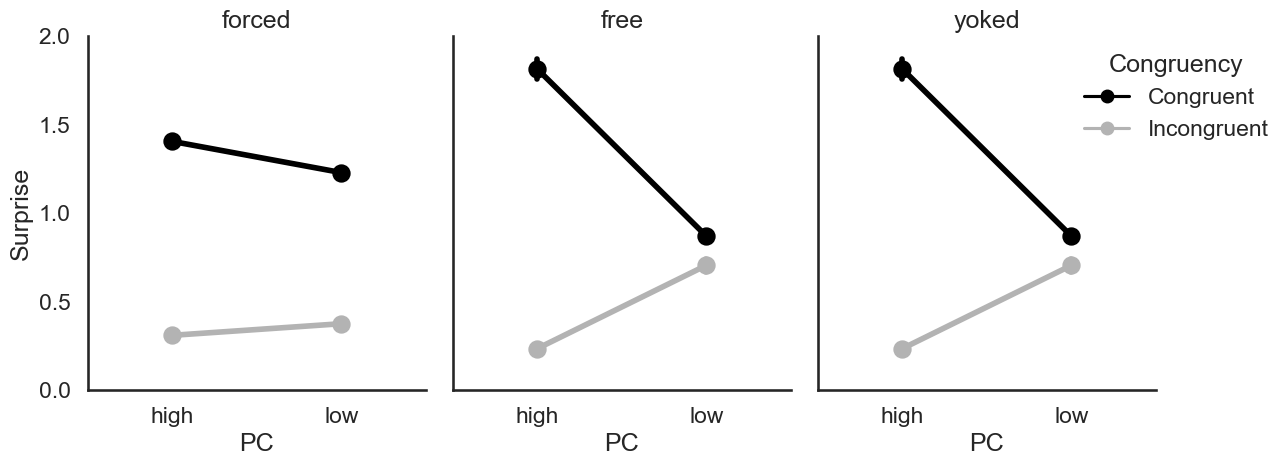

In [34]:
# Plot CSPC effect in all conditions
from matplotlib.lines import Line2D

data['location'] = data['location'].replace({'lower': 'low', 'upper': 'high'})

sns.set(style="white", context="talk")  # larger labels, clean background

print(np.unique(data['model']))
for model in np.unique(data['model']):
    data_model = data.loc[data['model'] == model]
    g = sns.catplot(
        data=data_model,
        x="location", y="surprise",
        hue="congruency",
        col="condition",
        kind="point",
        join=True,
        order=['high', 'low'],
        errorbar="se",                # plot standard error
        palette=["black", "0.7"],     # black + light gray
        legend=False,                 # we’ll make our own legend
        height=5.0, aspect=0.8
    )

    # Axis labels & limits
    g.set_axis_labels("PC", "Surprise")
    g.set(ylim=(0, 2.0))
    g.set_titles("{col_name}")

    # Turn off grid and tweak spines for a minimal look
    for ax in g.axes.flat:
        ax.grid(False)
        sns.despine(ax=ax)

    # Custom legend that uses points + lines
    legend_elements = [
        Line2D([0], [0], marker='o', linestyle='-',
               color='black', label='Congruent'),
        Line2D([0], [0], marker='o', linestyle='-',
               color='0.7', label='Incongruent')
    ]

    g.fig.legend(
        handles=legend_elements,
        title="Congruency",
        loc="upper left",
        bbox_to_anchor=(0.9, 0.9),
        frameon=False
    )

    plt.tight_layout()
    plt.savefig('latent_predictions.pdf', bbox_inches='tight')
    plt.show()

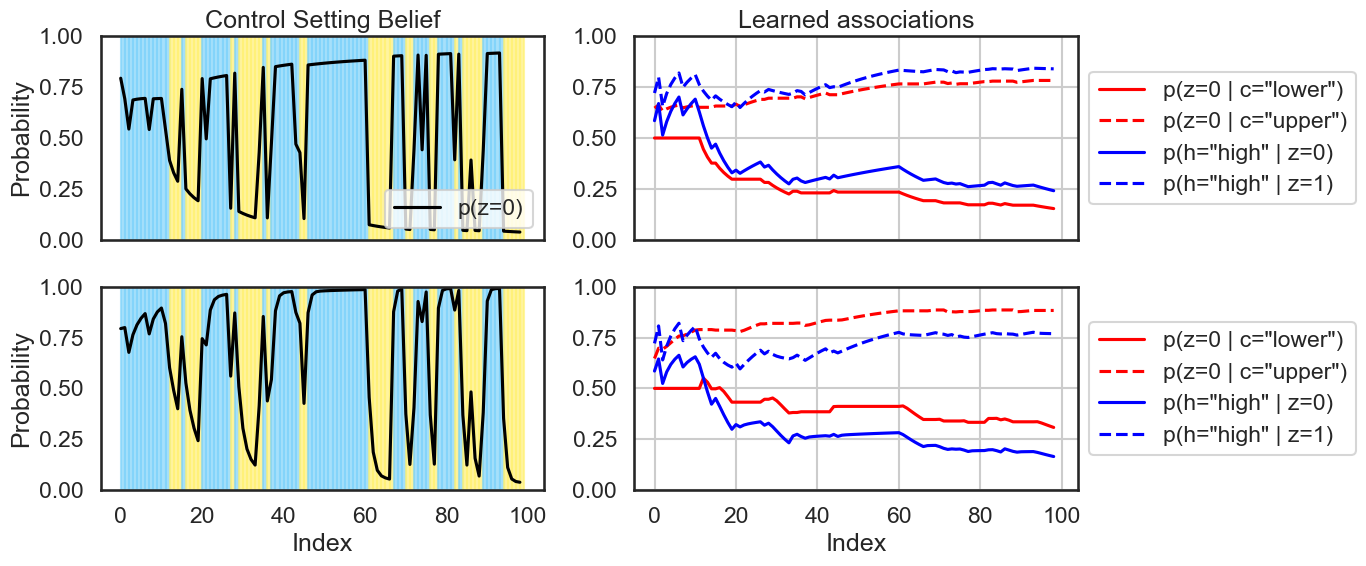

In [ ]:
# Plot latent inference example for latent and scheduling models
pc = [.2, .8]
con_exp = .7
stability_data = .8

stims = gen_stims(100, stability=stability_data, csc=pc)
data_latent = sim_cspc_latent(stability_data, pc, init_stability=.8, con_exp=con_exp, stims=stims)
data_schedule = sim_cspc_schedule(stability_data, pc, stability_assumption=.8, con_exp=con_exp, stims=stims)

fig, axs = plt.subplots(2, 2, figsize=(14, 6), sharex=True)

# Plot c_posterior
axs[0, 0].plot(data_latent.index, data_latent['c_posterior'], label='p(z=0)', color='black')
for idx, loc in enumerate(data_latent['location']):
    axs[0, 0].axvspan(idx, idx+1, color='#81d4fa' if loc == 'upper' else '#fff176', alpha=0.7)
axs[0, 0].set_ylabel('Probability')
axs[0, 0].set_title('Control Setting Belief')
axs[0, 0].set_ylim((0, 1))
axs[0, 0].legend()

# Plot p_c__l0 and p_e__c0
axs[0, 1].plot(data_latent.index, data_latent['p_c__l0'], label='p(z=0 | c="lower")', color='red')
axs[0, 1].plot(data_latent.index, data_latent['p_c__l1'], label='p(z=0 | c="upper")', color='red', linestyle='--')
axs[0, 1].plot(data_latent.index, data_latent['p_e__c1'], label='p(h="high" | z=0)', color='blue')
axs[0, 1].plot(data_latent.index, data_latent['p_e__c0'], label='p(h="high" | z=1)', color='blue', linestyle='--')
axs[0, 1].set_title('Learned associations')
axs[0, 1].set_ylim((0, 1))
axs[0, 1].grid(True)
axs[0, 1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Plot c_posterior
axs[1, 0].plot(data_schedule.index, data_schedule['c_posterior'], label='p(z=0)', color='black')
for idx, loc in enumerate(data_schedule['location']):
    axs[1, 0].axvspan(idx, idx+1, color='#81d4fa' if loc == 'upper' else '#fff176', alpha=0.7)
axs[1, 0].set_ylabel('Probability')
axs[1, 0].set_xlabel('Index')
axs[1, 0].set_ylim((0, 1))

# Plot p_c__l0 and p_e__c0
axs[1, 1].plot(data_schedule.index, data_schedule['p_c__l0'], label='p(z=0 | c="lower")', color='red')
axs[1, 1].plot(data_schedule.index, data_schedule['p_c__l1'], label='p(z=0 | c="upper")', color='red', linestyle='--')
axs[1, 1].plot(data_schedule.index, data_schedule['p_e__c1'], label='p(h="high" | z=0)', color='blue')
axs[1, 1].plot(data_schedule.index, data_schedule['p_e__c0'], label='p(h="high" | z=1)', color='blue', linestyle='--')
axs[1, 1].set_xlabel('Index')
axs[1, 1].set_ylim((0, 1))
#axs[1, 1].set_xlim((0, 100))
axs[1, 1].grid(True)
axs[1, 1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.savefig('dynamics.pdf', bbox_inches='tight')
plt.show()

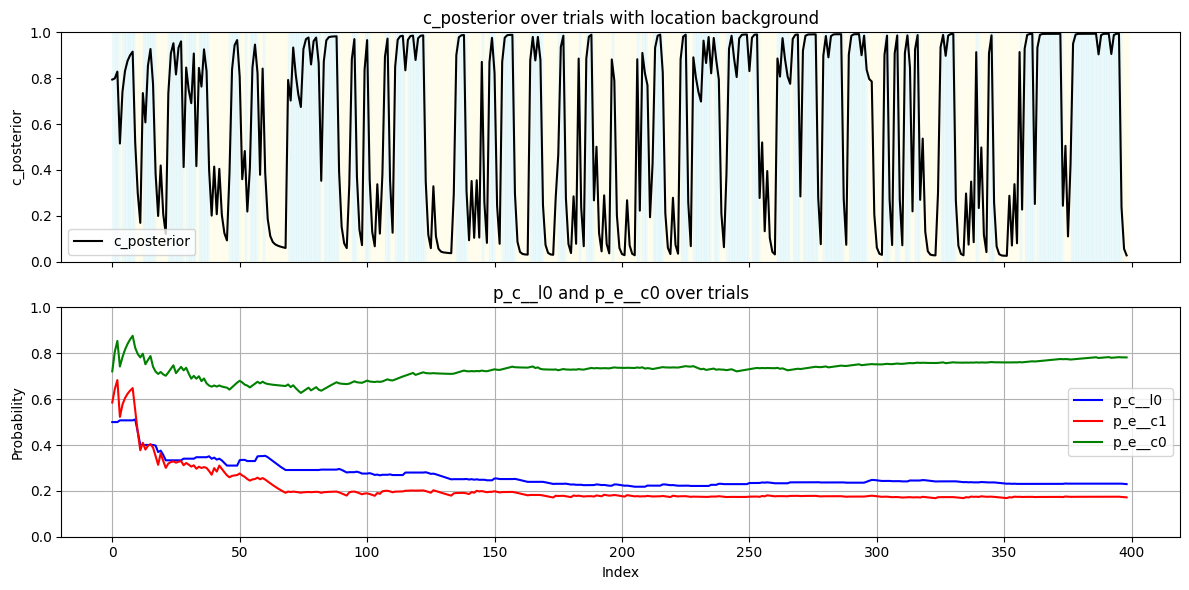

In [ ]:
stims = gen_stims(400, stability=.8, csc=[.2, .8])
s_model = SchedulingModel(stability=.8)
data = []
for i, stim in enumerate(stims):
    s_model.predict_entropy(stim[0])
    s_model.observe_entropy(stim[0], stim[1])
    s_model.learn(stim[0], stim[1])
    s_model.update_c()

    data.append({
        'location': stim[0],
        'congruency': stim[1],
        'c_proactive': s_model.c_proactive[0],
        'c_reactive': s_model.c_reactive[0],
        'c_posterior': s_model.c_posterior[0],
        'e_prediction': s_model.e_prediction[0],
        'p_c__l0': s_model.theta.get_mean_cpd()[0, 0],
        'p_c__l1': s_model.theta.get_mean_cpd()[0, 1],
        'p_e__c0': s_model.phi.get_mean_cpd()[0, 0],
        'p_e__c1': s_model.phi.get_mean_cpd()[0, 1],
    })

data = pd.DataFrame(data)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Plot c_posterior
ax1.plot(data.index, data['c_posterior'], label='c_posterior', color='black')
for idx, loc in enumerate(data['location']):
    ax1.axvspan(idx, idx+1, color='#e0f7fa' if loc == 'upper' else '#fffde7', alpha=0.5)
ax1.set_ylabel('c_posterior')
ax1.set_title('c_posterior over trials with location background')
ax1.set_ylim((0, 1))
ax1.legend()

# Plot p_c__l0 and p_e__c0
ax2.plot(data.index, data['p_c__l0'], label='p_c__l0', color='blue')
ax2.plot(data.index, data['p_c__l1'], label='p_c__l1', color='yellow')
ax2.plot(data.index, data['p_e__c1'], label='p_e__c1', color='red')
ax2.plot(data.index, data['p_e__c0'], label='p_e__c0', color='green')
ax2.set_xlabel('Index')
ax2.set_ylabel('Probability')
ax2.set_title('p_c__l0 and p_e__c0 over trials')
ax2.set_ylim((0, 1))
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

# Other code

In [ ]:
# Run only intention model
data = pd.DataFrame()
pc = [.2, .8]
con_exp = .7

for i in range(5):
    data_intention_i = sim_cspc_intention(.5, pc, free_choice=False, int_strength=.6, con_exp=con_exp)
    data_intention_i['model'] = 'intention'
    data_intention_i['id'] = i
    data_intention_i['condition'] = 'forced'
    data = pd.concat((data, data_intention_i))

for i in range(5):
    data_intention_i = sim_cspc_intention(.8, pc, free_choice=True, int_strength=.6, con_exp=con_exp)
    data_intention_i['model'] = 'intention'
    data_intention_i['id'] = i
    data_intention_i['condition'] = 'free'
    data = pd.concat((data, data_intention_i))

for i in range(5):
    data_intention_i = sim_cspc_intention(.8, pc, free_choice=False, int_strength=.6, con_exp=con_exp)
    data_intention_i['model'] = 'intention'
    data_intention_i['id'] = i
    data_intention_i['condition'] = 'yoked'
    data = pd.concat((data, data_intention_i))

In [ ]:
# Run only latent model
data = pd.DataFrame()
pc = [.2, .8]
con_exp = .7

for i in range(10):
    data_intention_i = sim_cspc_latent(.5, pc, con_exp=con_exp, n=20)
    data_intention_i['model'] = 'latent'
    data_intention_i['id'] = i
    data_intention_i['condition'] = 'forced'
    data = pd.concat((data, data_intention_i))

for i in range(10):
    data_intention_i = sim_cspc_latent(.8, pc, con_exp=con_exp, n=20)
    data_intention_i['model'] = 'latent'
    data_intention_i['id'] = i
    data_intention_i['condition'] = 'free'
    data = pd.concat((data, data_intention_i))

for i in range(10):
    data_intention_i = sim_cspc_latent(.8, pc, con_exp=con_exp, n=20)
    data_intention_i['model'] = 'latent'
    data_intention_i['id'] = i
    data_intention_i['condition'] = 'yoked'
    data = pd.concat((data, data_intention_i))

In [ ]:
# Run only scheduling model
data = pd.DataFrame()
pc = [.2, .8]
con_exp = .7

for i in range(10):
    data_schedule_i = sim_cspc_schedule(.5, pc, stability_assumption=.8, con_exp=con_exp)
    data_schedule_i['model'] = 'schedule'
    data_schedule_i['id'] = i
    data_schedule_i['condition'] = 'forced'
    data = pd.concat((data, data_schedule_i))

for i in range(10):
    data_schedule_i = sim_cspc_schedule(.8, pc, stability_assumption=.8, con_exp=con_exp)
    data_schedule_i['model'] = 'schedule'
    data_schedule_i['id'] = i
    data_schedule_i['condition'] = 'free'
    data = pd.concat((data, data_schedule_i))

for i in range(10):
    data_schedule_i = sim_cspc_schedule(.8, pc, stability_assumption=.8, con_exp=con_exp)
    data_schedule_i['model'] = 'schedule'
    data_schedule_i['id'] = i
    data_schedule_i['condition'] = 'yoked'
    data = pd.concat((data, data_schedule_i))